In [1]:
import pandas as pd
%matplotlib inline
import pymc3 as pm
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')

In [2]:
baseline_name = 'Water'

data = pd.read_csv('bandoro-microbiome.csv')

# Encode the "Sample" column with indices.
sample_names = dict()
for i, name in enumerate(sorted(np.unique(data['Sample'].values))):
    sample_names[name] = i

for name, i in sample_names.items():
    data['Indices'] = data['Sample'].apply(lambda x: sample_names[x])
    
data = data.sort('Indices')
    
    
baseline_idx = sample_names[baseline_name]
indices = list(set(data['Indices']))
indices.remove(baseline_idx)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


/Users/ericmjl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [3]:
with pm.Model() as model:
    # Hyperpriors
    upper = pm.Exponential('upper', lam=0.05)
    # lower = pm.Exponential('lower', lam=1)

    # "fold", which is the estimated fold change.
    fold = pm.Uniform('fold', lower=1E-10, upper=upper, shape=len(sample_names))

    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    # sigma = pm.Gamma('sigma', alpha=1, beta=1, shape=n_genotypes+2)
    sigma = pm.HalfCauchy('sigma', beta=1, shape=len(sample_names))

    # Model prediction
    mu = fold[data['Indices']]
    sig = sigma[data['Indices']]

    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sig, observed=data['Normalized % GFP'])
    
    z_factor = pm.Deterministic('z_factor', 1 - (3 * sigma[indices, :] + 3 * sigma[baseline_idx]) / np.abs(fold[indices, :] - fold[baseline_idx]))

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [4]:
with model:
    n_steps = 100000
    params = pm.variational.advi(n=n_steps)
    trace = pm.variational.sample_vp(params, draws=2000)


Iteration 0 [0%]: ELBO = -248472.13
Iteration 10000 [10%]: Average ELBO = -87795.51
Iteration 20000 [20%]: Average ELBO = -378.17
Iteration 30000 [30%]: Average ELBO = -288.19
Iteration 40000 [40%]: Average ELBO = -284.04
Iteration 50000 [50%]: Average ELBO = -282.89
Iteration 60000 [60%]: Average ELBO = -282.08
Iteration 70000 [70%]: Average ELBO = -281.26
Iteration 80000 [80%]: Average ELBO = -280.37
Iteration 90000 [90%]: Average ELBO = -280.17
Finished [100%]: Average ELBO = -279.97


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11305f6d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113592630>]], dtype=object)

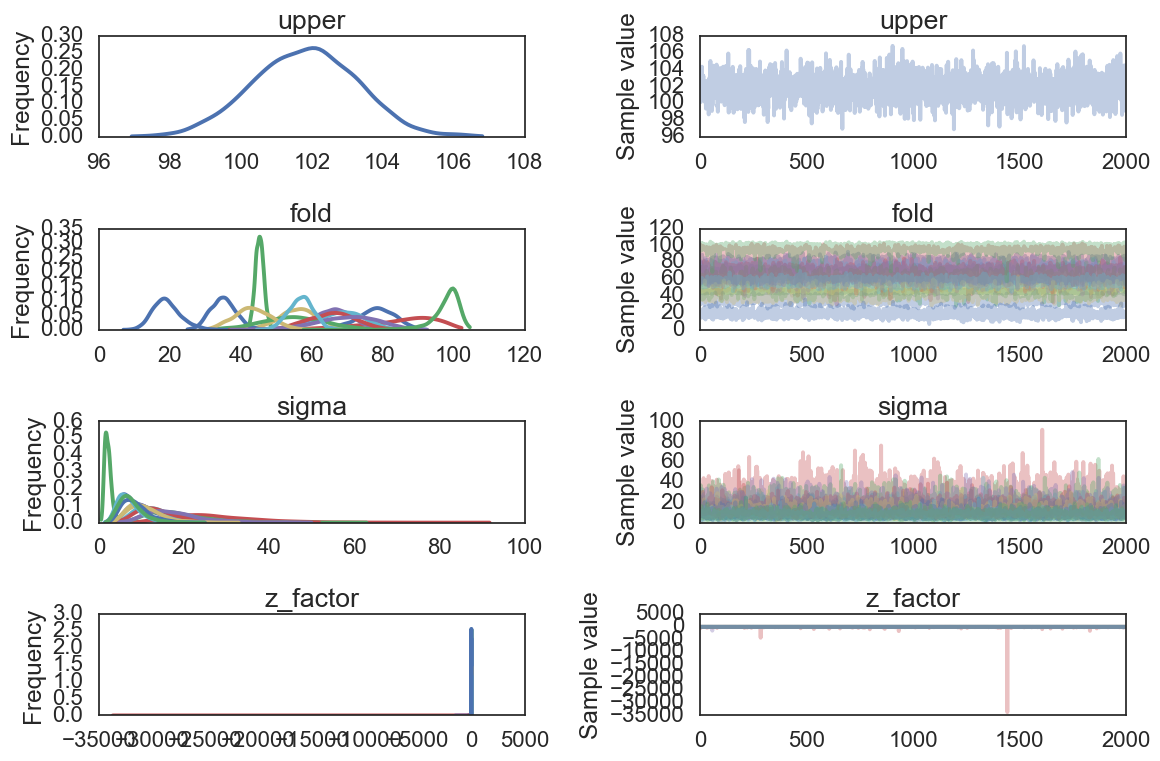

In [5]:
pm.traceplot(trace)

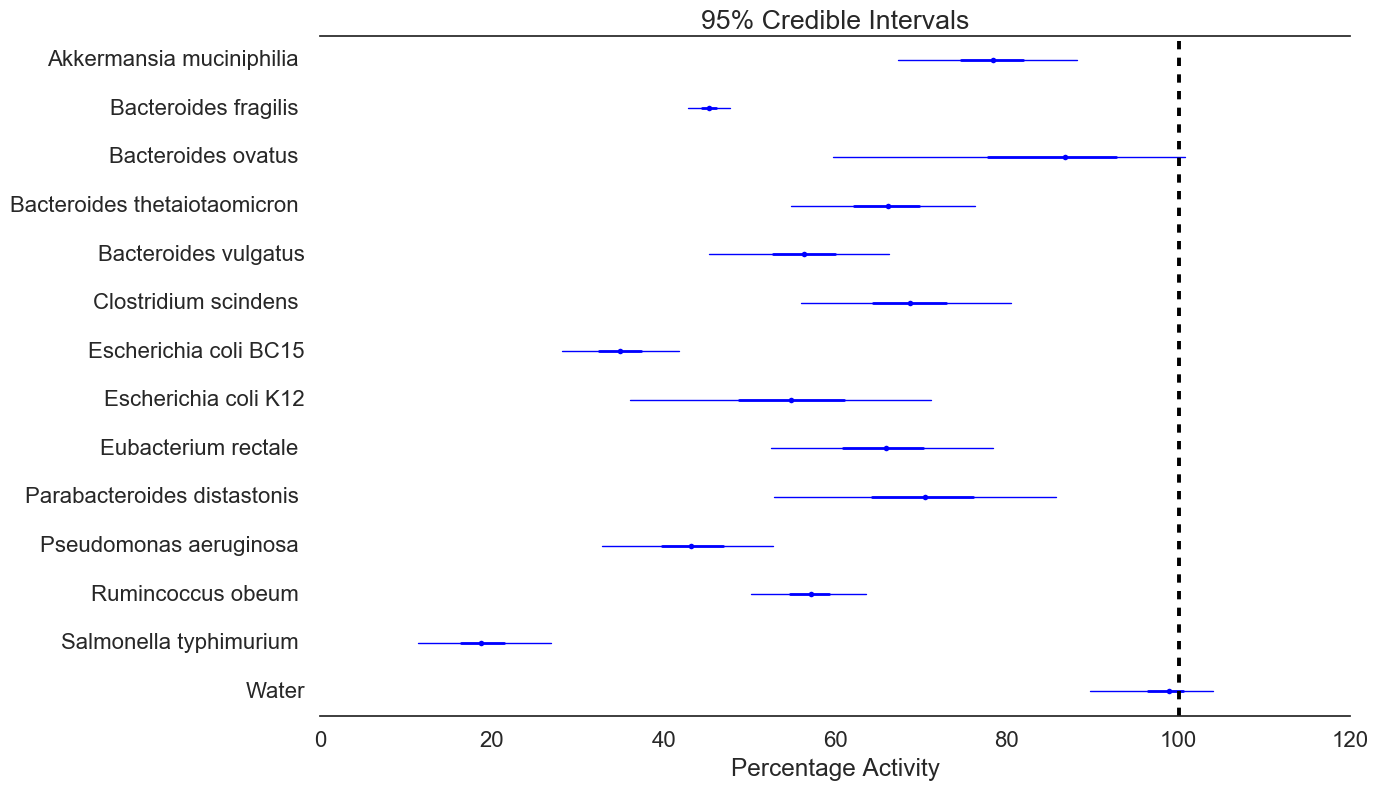

In [6]:
fig = plt.figure(figsize=(20, 8))
pm.forestplot(trace, varnames=['fold'], vline=100, ylabels=sorted(sample_names), xtitle='Percentage Activity', xrange=(0, 120))
plt.savefig('../figures/bandoro-microbiome-bayes.pdf', bbox_inches='tight')

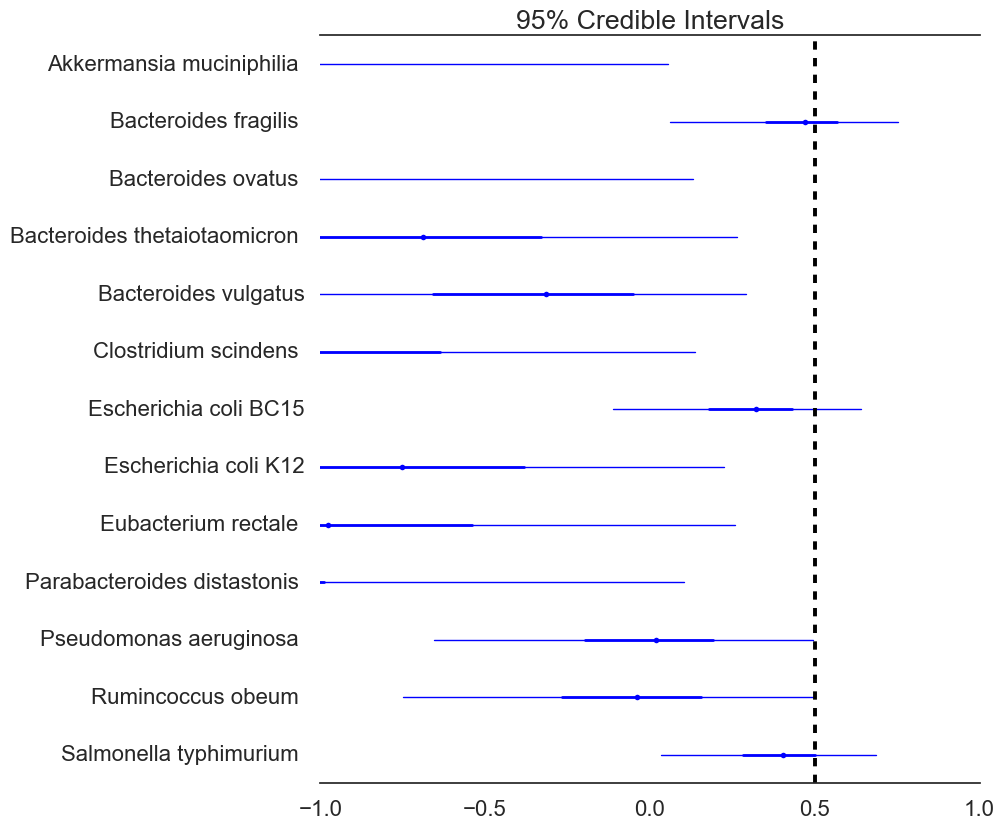

In [7]:
pm.forestplot(trace, varnames=['z_factor'], xrange=(-1, 1), vline=0.5, ylabels=sorted(set(sample_names).difference([baseline_name])))

In [8]:
trace.varnames

['upper', 'fold', 'sigma', 'z_factor']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x111d17f60>], dtype=object)

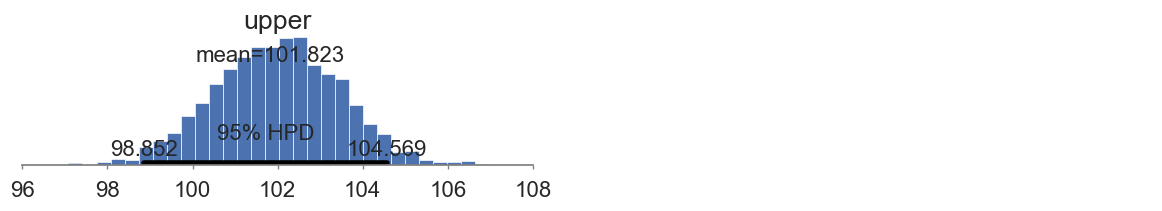

In [9]:
pm.plot_posterior(trace, varnames=['upper'], plot_transformed=True)

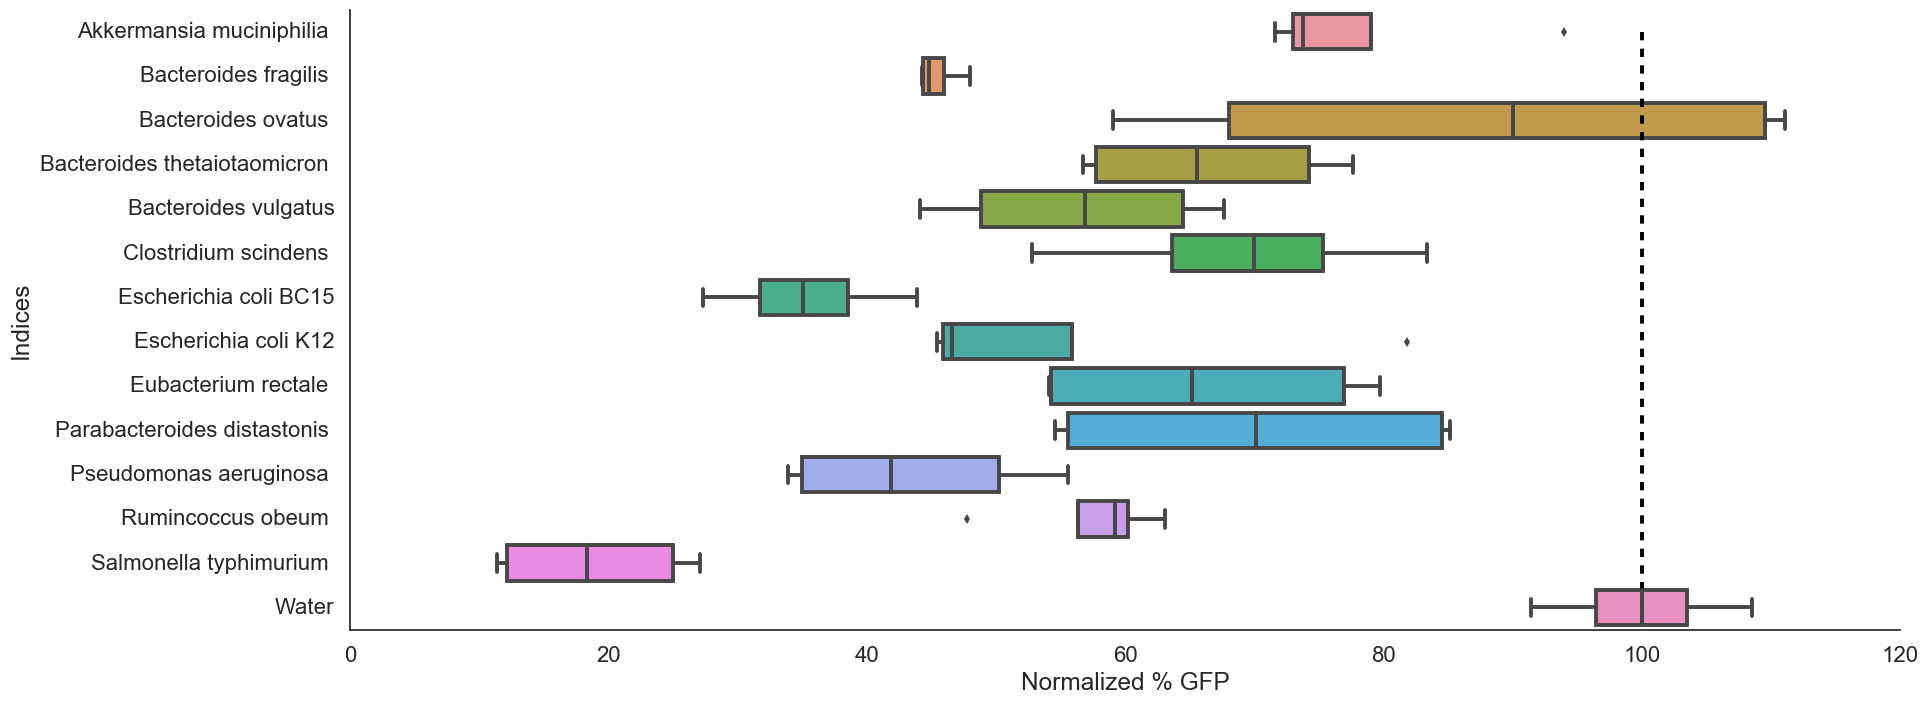

In [10]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
# data.plot(kind='scatter', y='Normalized % GFP', x='Indices', ax=ax)
# data.boxplot(column='Normalized % GFP', by='Indices', ax=ax)
sns.boxplot(data=data, y='Indices', x='Normalized % GFP', orient='h')
plt.yticks(range(len(sample_names)), sorted(sample_names))
ax.vlines(x=100, ymin=0, ymax=len(sample_names), linestyle='--')
sns.despine()
plt.savefig('../figures/bandoro-microbiome-data.pdf', bbox_inches='tight')

/Users/ericmjl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


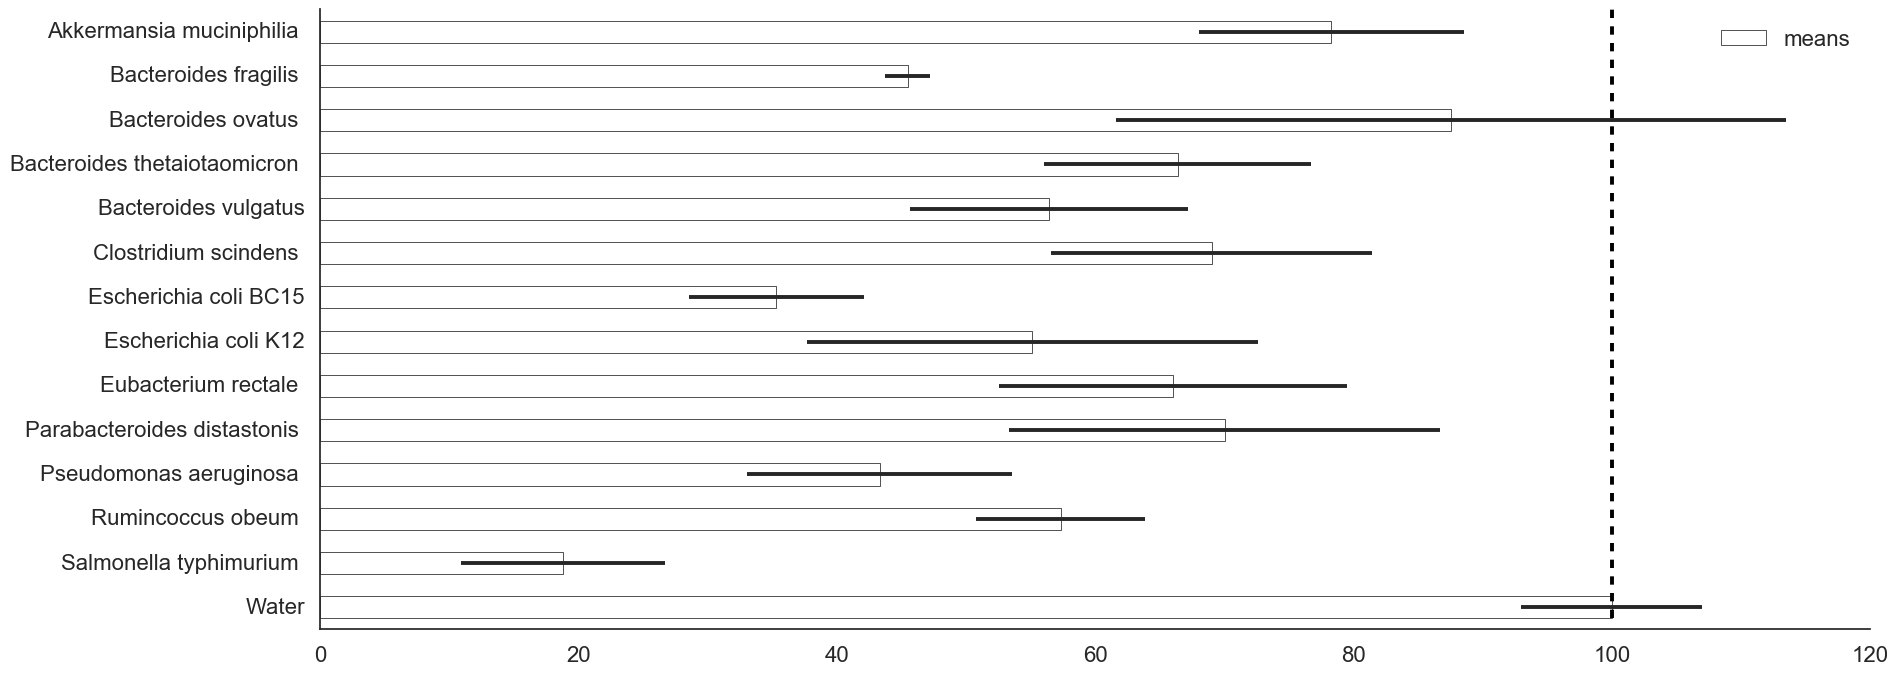

In [11]:
means = data.groupby('Indices').mean()['Normalized % GFP']
ci_width = data.groupby('Indices').std()['Normalized % GFP'] / np.sqrt(4)

freq_df = pd.DataFrame()
freq_df['means'] = data.groupby('Indices').mean()['Normalized % GFP']
freq_df['std'] = data.groupby('Indices').std()['Normalized % GFP']
freq_df['ci'] = freq_df['std'] / np.sqrt(4) * 1.96
freq_df.reset_index(inplace=True)
freq_df['Indices'] = np.abs(freq_df['Indices'] - len(freq_df)+1)
freq_df.sort('Indices').plot(kind='barh', x='Indices', y='means', xerr='ci', color='white', figsize=(20,8))

ax = plt.gca()
ax.set_yticklabels(sorted(sample_names, reverse=True))
ax.set_ylabel('')
ax.vlines(x=100, ymin=0-0.25, ymax=len(sample_names)-0.25, linestyle='--')

sns.despine()

plt.savefig('../figures/bandoro-microbiome-frequentist.pdf', bbox_inches='tight')

In [12]:
data.groupby('Sample').mean().sort('Normalized % GFP', ascending=False)

/Users/ericmjl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,% GFP,Normalized % GFP,Replicate,Indices
Sample,,,,
Water,20.0750,100.000000,2.5,13.0
Bacteroides ovatus,18.4425,87.525871,2.5,2.0
Akkermansia muciniphilia,15.9250,78.277791,2.5,0.0
Parabacteroides distastonis,14.6250,70.003415,2.5,9.0
Clostridium scindens,13.8875,68.996463,2.5,5.0
Bacteroides thetaiotaomicron,13.6750,66.386376,2.5,3.0
Eubacterium rectale,13.7150,66.034047,2.5,8.0
Rumincoccus obeum,11.6550,57.312946,2.5,11.0
Bacteroides vulgatus,11.6775,56.403161,2.5,4.0


In [13]:
means = trace['fold'].mean(axis=0)
mean_df = pd.DataFrame()
mean_df['means'] = means
mean_df['sample'] = sample_names
mean_df.sort('means', ascending=False)

/Users/ericmjl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,means,sample
13,97.881286,Akkermansia muciniphilia
2,84.041302,Bacteroides vulgatus
0,77.991182,Bacteroides fragilis
9,69.764139,Bacteroides ovatus
5,68.460453,Escherichia coli BC15
3,65.796779,Rumincoccus obeum
8,65.593622,Salmonella typhimurium
11,56.969975,Water
4,56.343060,Escherichia coli K12
7,54.815748,Clostridium scindens


In [14]:
freq_width = freq_df['ci'] * 2
data_range = data.groupby('Indices')['Normalized % GFP'].max() - data.groupby('Indices')['Normalized % GFP'].min()
bayes_low, bayes_high = np.percentile(trace['fold'], [2.5, 97.5], axis=0)
bayes_range = bayes_high - bayes_low

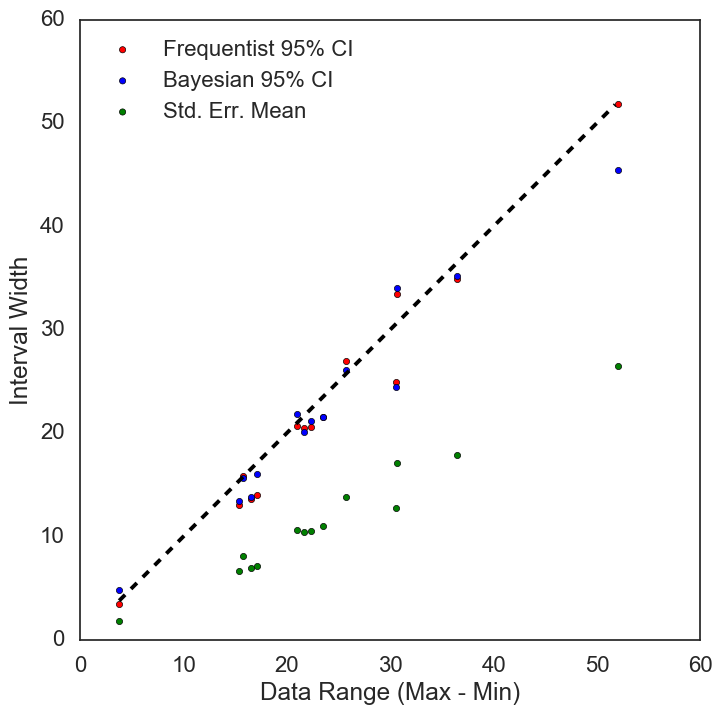

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

range_df = pd.DataFrame()
range_df['frequentist'] = freq_width
range_df['sem'] = freq_width / 1.96
range_df['data'] = data_range
range_df['bayesian'] = bayes_range
range_df.plot(kind='scatter', x='data', y='frequentist', ax=ax, color='red', label='Frequentist 95% CI')
range_df.plot(kind='scatter', x='data', y='bayesian', ax=ax, color='blue', label='Bayesian 95% CI')
range_df.plot(kind='scatter', x='data', y='sem', ax=ax, color='green', label='Std. Err. Mean')
plt.plot(np.arange(min(range_df['data']), max(range_df['data'])), np.arange(min(range_df['data']), max(range_df['data'])), color='black', linestyle='--')
plt.ylabel('Interval Width')
plt.xlabel('Data Range (Max - Min)')
plt.ylim(ax.get_xlim())


plt.savefig('../figures/bandoro-range-estimates.pdf', bbox_inches='tight')

In [16]:
out = pm.summary(trace)


upper:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  101.823          1.490            0.034            [98.852, 104.569]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  98.921         100.829        101.846        102.852        104.771


fold:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  77.991           5.423            0.129            [67.292, 88.217]
  45.305           1.216            0.032            [42.887, 47.717]
  84.041           11.920           0.248            [59.759, 100.693]
  65.797           5.547            0.122            [54.804, 76.308]
  56.343           5.439            0.120            [45.239, 66.283]
  68.460           6.318            0.151     

In [17]:
pm.df_summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
upper,101.822839,1.489787,0.033621,98.851745,104.568530
fold__0,77.991182,5.422817,0.129464,67.292208,88.216787
fold__1,45.304642,1.216090,0.031668,42.887414,47.717157
fold__2,84.041302,11.920339,0.247710,59.758688,100.693056
fold__3,65.796779,5.547278,0.122183,54.803630,76.308131
fold__4,56.343060,5.439362,0.119572,45.239186,66.282876
fold__5,68.460453,6.318015,0.150680,56.058193,80.477661
fold__6,35.036915,3.555586,0.080912,28.106640,41.742738
fold__7,54.815748,8.863100,0.192737,36.123839,71.155317
fold__8,65.593622,6.785368,0.152228,52.454760,78.330050


In [18]:
pm.forestplot(trace, ylabels=)

SyntaxError: invalid syntax (<ipython-input-18-4fced8160dfd>, line 1)